In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt, matplotlib
import numpy as np, healpy as hp, h5py
from scipy import stats, special, linalg, optimize
import emcee, tqdm, corner

from pylab import cm

## Load data

In [3]:
nside=128
def downsize(arr, nbig, nsmall):
    return np.sum(np.reshape(arr, (-1,int((nbig/nsmall)**2+0.1))), axis=1)
def logit(p):
    return np.log(p/(1-p))
n2r = hp.ring2nest(nside, np.arange(hp.nside2npix(nside)))

In [6]:
data = {}
mag = 20.
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_hpx10.h', 'r') as hf:
    magid = np.argwhere(hf['magval'][...]==mag)[0,0]
    data['n'] = np.zeros(hp.nside2npix(128))
    data['n'][hf[str(magid)]['hpx'][...]] = hf[str(magid)]['n'][...]
    data['n'] = downsize(data['n'], 128, nside)[n2r]
    data['k'] = np.zeros(hp.nside2npix(128))
    data['k'][hf[str(magid)]['hpx'][...]] = hf[str(magid)]['k_ast'][...]
    data['k'] = downsize(data['k'], 128, nside)[n2r]

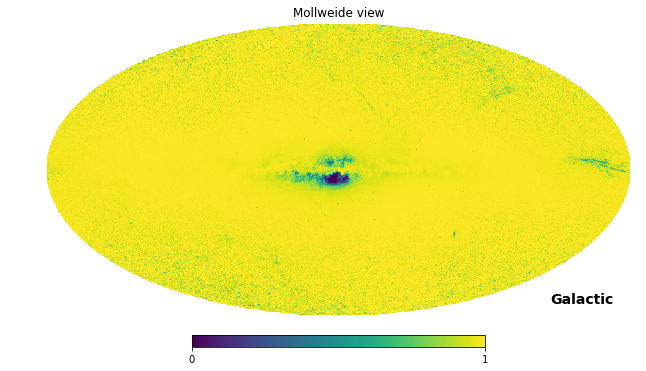

In [7]:
hp.mollview(data['k']/data['n'], coord=['C','G'])

In [65]:
x

array([       inf,        inf, 3.61091791, ..., 3.76120012, 3.83945231,
       4.24849524])

In [71]:
np.min(data['n'][data['k']>0])

1.0

In [72]:
x = np.where(data['k']>0, data['k']/data['n'], 1)

In [79]:
5*((data['k']>0).astype(int)*2-1)

array([5, 5, 5, ..., 5, 5, 5])

/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


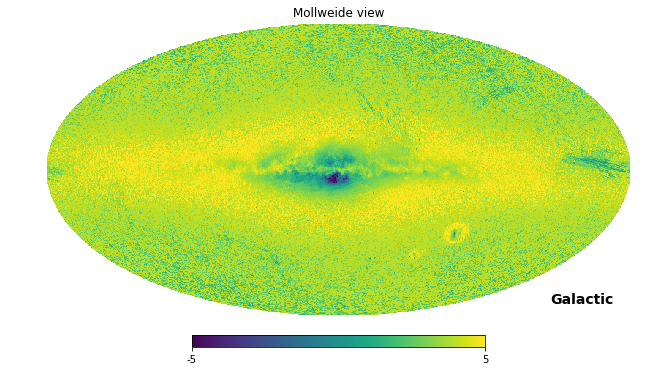

In [94]:
x = np.where((data['k']>0)&(data['k']<data['n']), logit(data['k']/data['n']),
                                4*((data['k']>0).astype(int)*2-1))
#x[np.isinf(x)] = 1.
hp.mollview(x, coord=['C','G'], min=-5,max=5)

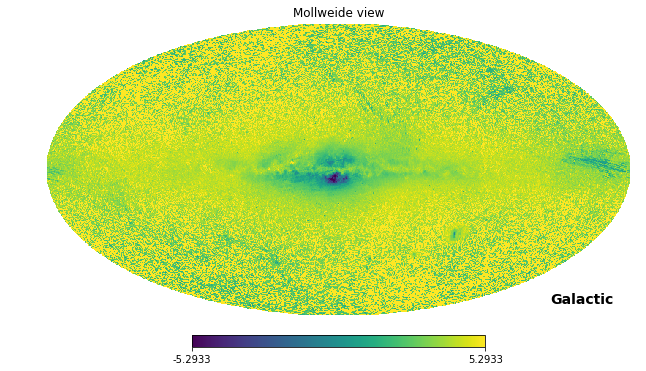

In [9]:
x = np.where((data['n']>0), logit(data['k']/data['n'] *0.99+0.005),
                                4*((data['k']>0).astype(int)*2-1))
#x[np.isinf(x)] = 1.
hp.mollview(x, coord=['C','G'])

## Spherical harmonic - wavelet transform

In [10]:
lmax = [10,30,100]

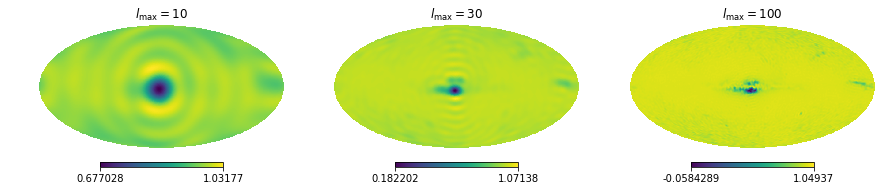

In [97]:
fig, ax = plt.subplots(1,len(lmax), figsize=(5*len(lmax), 5))
for i in range(len(lmax)):
    plt.sca(ax[i])
    alm_map = hp.map2alm((data['k']/data['n']), lmax=lmax[i])
    _map = hp.alm2map(alm_map, nside, verbose=False)
    hp.mollview(_map, coord=['C','G'], hold=True, notext=True, title=r'$l_\mathrm{max} = %d$'%lmax[i])

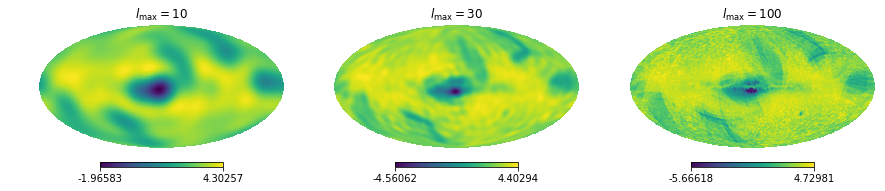

In [155]:
fig, ax = plt.subplots(1,len(lmax), figsize=(5*len(lmax), 5))
for i in range(len(lmax)):
    plt.sca(ax[i])
    alm_map = hp.map2alm(x, lmax=lmax[i])
    _map = hp.alm2map(alm_map, nside, verbose=False)
    hp.mollview(_map, coord=['C','G'], hold=True, notext=True, title=r'$l_\mathrm{max} = %d$'%lmax[i])

### Power spectrum

/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


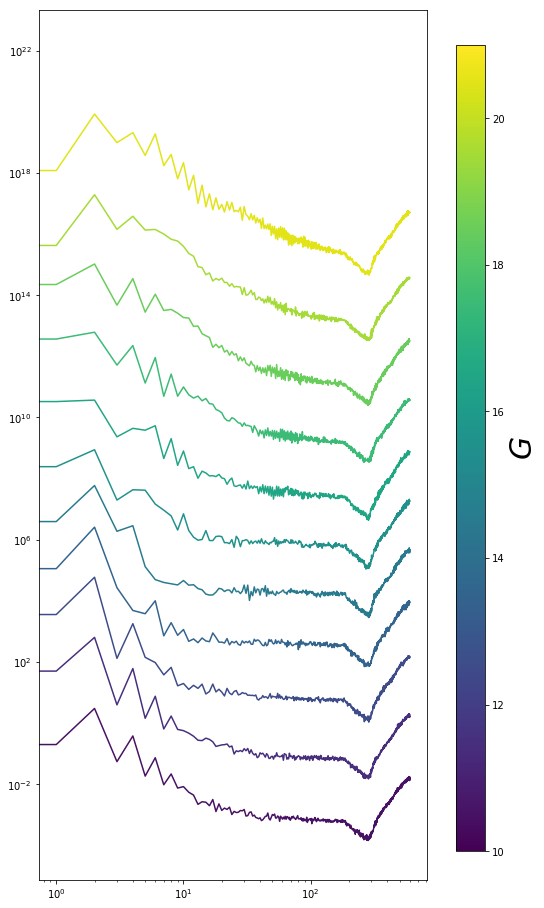

In [14]:
fig = plt.figure(figsize=(8,16))

cmap = cm.viridis; mmin=10.; mmax=21.

lmax=600
for i, mag in enumerate(np.arange(10.5,21.,1.)):

    data = {}
    with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts.h', 'r') as hf:
        magid = np.argwhere(hf['magval'][...]==mag)[0,0]
        data['n'] = np.zeros(hp.nside2npix(128))
        data['n'][hf[str(magid)]['hpx'][...]] = hf[str(magid)]['n'][...]
        data['n'] = downsize(data['n'], 128, nside)[n2r]
        data['k'] = np.zeros(hp.nside2npix(128))
        data['k'][hf[str(magid)]['hpx'][...]] = hf[str(magid)]['k'][...]
        data['k'] = downsize(data['k'], 128, nside)[n2r]
        
    x = np.where((data['k']>0)&(data['k']<data['n']), logit(data['k']/data['n']),
                                4*((data['k']>0).astype(int)*2-1))
        
    spectrum = hp.anafast(x, lmax=lmax) * 10**(2*i)
    plt.plot(np.arange(lmax+1), spectrum, color=cmap((mag-mmin)/(mmax-mmin)))
    #plt.plot(np.repeat(np.arange(lmax+2),2)[1:-1]-0.5, np.repeat(spectrum,2), color=cmap((mag-mmin)/(mmax-mmin)))
plt.yscale('log'); plt.xscale('log')
    
# Adding cbar axes to subplots
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=30)

## Source density power spectrum

/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


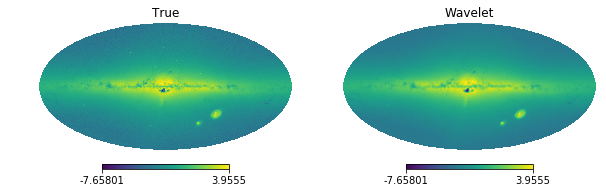

In [16]:
lmax=100

data = {}
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts.h', 'r') as hf:
    magid = np.argwhere(hf['magval'][...]==mag)[0,0]
    data['n'] = np.zeros(hp.nside2npix(128))
    data['n'][hf[str(magid)]['hpx'][...]] = hf[str(magid)]['n'][...]
    data['n'] = downsize(data['n'], 128, nside)[n2r]


n_mean = np.sum(data['n'])/hp.nside2npix(nside)
x = np.where((data['n']>0), np.log(data['n']/n_mean),
                            -10)

fig, ax = plt.subplots(1,2, figsize=(10, 5))

plt.sca(ax[1])
alm_map = hp.map2alm(x, lmax=lmax)
_map = hp.alm2map(alm_map, nside, verbose=False)
hp.mollview(_map, coord=['C','G'], hold=True, notext=True, title='Wavelet')

plt.sca(ax[0])
hp.mollview(x, coord=['C','G'], hold=True, notext=True, title='True', min=np.min(_map), max=np.max(_map))

/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


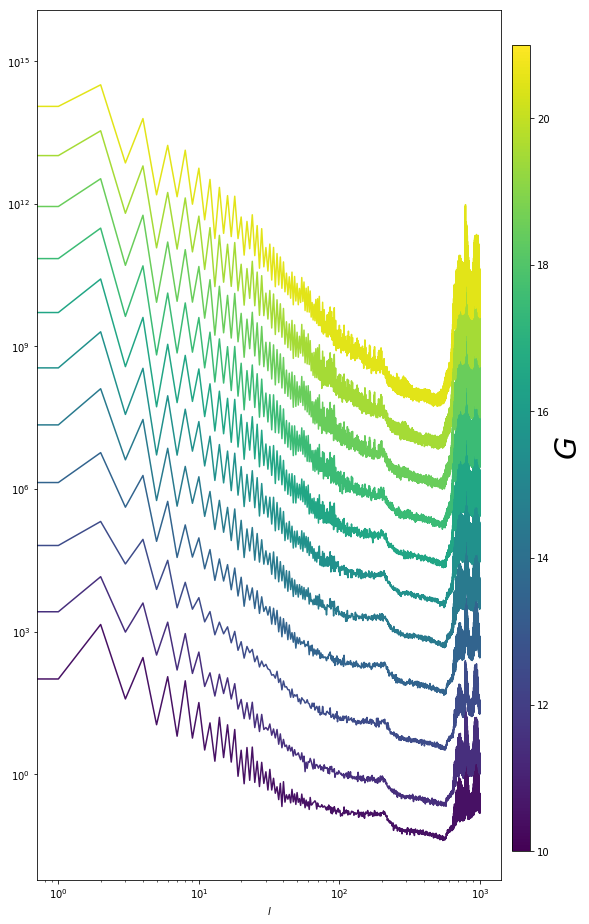

In [17]:
fig = plt.figure(figsize=(8,16))

cmap = cm.viridis; mmin=10.; mmax=21.

lmax=1000
for i, mag in enumerate(np.arange(10.5,21.,1.)):

    data = {}
    with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts.h', 'r') as hf:
        magid = np.argwhere(hf['magval'][...]==mag)[0,0]
        data['n'] = np.zeros(hp.nside2npix(128))
        data['n'][hf[str(magid)]['hpx'][...]] = hf[str(magid)]['n'][...]
        data['n'] = downsize(data['n'], 128, nside)[n2r]
        
        
    n_mean = np.sum(data['n'])/hp.nside2npix(nside)
    x = np.where((data['n']>0), np.log(data['n']/n_mean), 0)
        
    spectrum = hp.anafast(x, lmax=lmax) * 10**(i)
    plt.plot(np.arange(lmax+1), spectrum, color=cmap((mag-mmin)/(mmax-mmin)))
plt.yscale('log'); plt.xscale('log')
plt.xlabel(r'$l$')

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=30)

/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


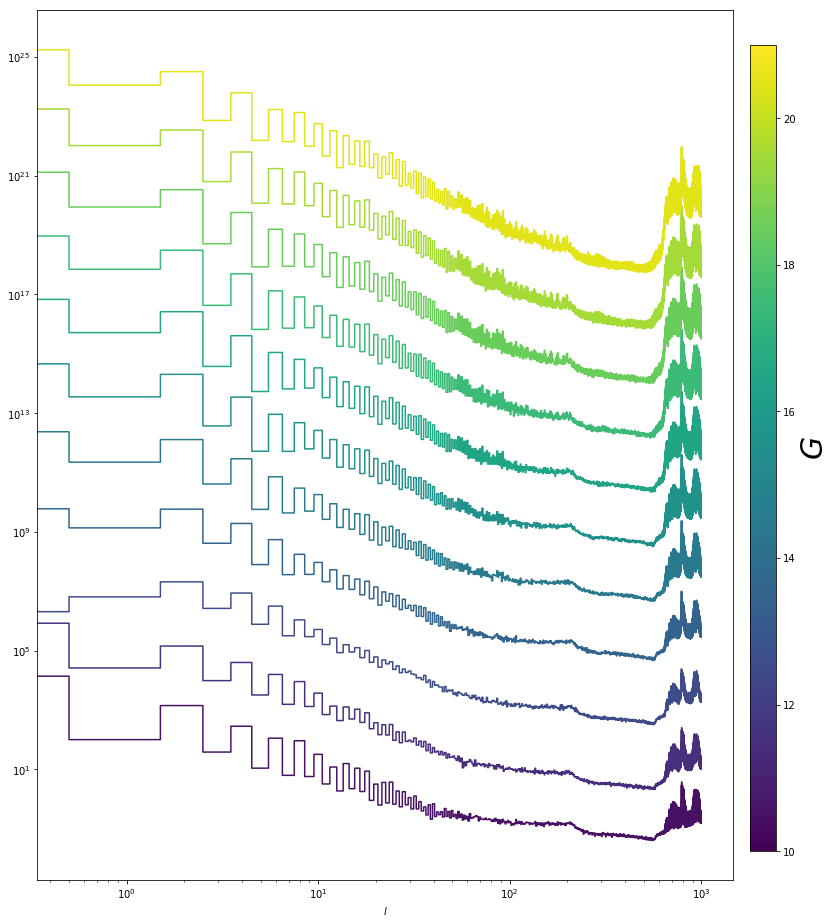

In [146]:
fig = plt.figure(figsize=(12,16))

cmap = cm.viridis; mmin=10.; mmax=21.

lmax=1000
for i, mag in enumerate(np.arange(10.5,21.,1.)):

    data = {}
    with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts.h', 'r') as hf:
        magid = np.argwhere(hf['magval'][...]==mag)[0,0]
        data['n'] = np.zeros(hp.nside2npix(128))
        data['n'][hf[str(magid)]['hpx'][...]] = hf[str(magid)]['n'][...]
        data['n'] = downsize(data['n'], 128, nside)[n2r]
        
        
    n_mean = np.sum(data['n'])/hp.nside2npix(nside)
    x = np.where((data['n']>0), np.log(data['n']/n_mean),
                                0)
        
    spectrum = hp.anafast(x, lmax=lmax) * 10**(2*i)
    plt.plot(np.repeat(np.arange(lmax+2),2)[1:-1]-0.5, np.repeat(spectrum,2),
                color=cmap((mag-mmin)/(mmax-mmin)))
plt.yscale('log'); plt.xscale('log')
plt.xlabel(r'$l$')

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=30)